In [382]:
import pandas as pd                      # Pacote PANDAS para a leitura e manipulação dos dados
import numpy as np                       # Pacote NUMPY usando para manipulação matemática de matrizes
import matplotlib.pyplot as plt          # Importa a função pyplot como plt para gerar os gráficos 
from scipy.interpolate import make_interp_spline, BSpline

<h2>Plotando as linhas equipotenciais para o caso básico (sem nenhum objeto entre as placas parelelas):</h2>

In [383]:
basico_df = pd.read_excel('./dados/experimento_base.xlsx')

In [384]:
#função para encontrar o vetor perpendicular entre dois pontos consecutivos
def perpline(X,Y,pos):
    dx = X[1]-X[0];
    dy = Y[1]-Y[0];
    
    Xbar = (X[0]+X[1])/2;
    Ybar = (Y[0]+Y[1])/2;
    
    nx=[];
    ny=[];
    
    nx.append(Xbar);
    nx.append(Xbar -np.sign(pos)* dy/(dx**2+dy**2)**(1/2));
    
    ny.append(Ybar);
    ny.append(Ybar +np.sign(pos)* dx/(dx**2+dy**2)**(1/2));
    
    return nx, ny

In [385]:
def plot_contour(df, file_name, razao_pontos=1, n_curvas=0):
  '''
  Plota n_curvas curvas de nivel usando os dados de df, tambem plota vetores perpendiculares aos pontos, o numero de vetores depende de razao_pontos
  ex: se razao_pontos = 2 pegara os pontos de df de 2 em 2
  '''

  fig, ax = plt.subplots(figsize=(12, 6))

  if n_curvas == 0:
    contourf = plt.tricontourf(df['x'], df['y'], df['mV'], cmap='coolwarm')
    contour = plt.tricontour(df['x'], df['y'], df['mV'], cmap='coolwarm')
  else:
    contourf = plt.tricontourf(df['x'], df['y'], df['mV'], n_curvas, cmap='coolwarm')
    contour = plt.tricontour(df['x'], df['y'], df['mV'], n_curvas, cmap='coolwarm')

  pc_slist = contour.collections

  for pc in pc_slist:
    paths = pc.get_paths()

    if len(paths) == 0:
      continue

    points = paths[0].vertices

    for i in range(len(points) - 2):
      if i % razao_pontos != 0:
        continue

      [nx,ny]= perpline([points[i][0], points[i + 1][0]],[points[i][1], points[i + 1][1]],+1); #encontra os pontos do vetor unitário perdicular 
        
      plt.quiver(nx[0],ny[0],nx[1]-nx[0],ny[1]-ny[0]  # gráfico de setas
                ,color='black', width=.003, scale=25)  # estilizacao dos vetores

  plt.xlabel('Posição Eixo X(cm)')
  plt.ylabel('Posição Eixo Y(cm)')

  plt.colorbar(contourf)

  fig.savefig(file_name)

  plt.show()

<h3>Distribuição dos pontos que foram utilizados para coletar os dados</h3>

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='x', ylabel='y'>

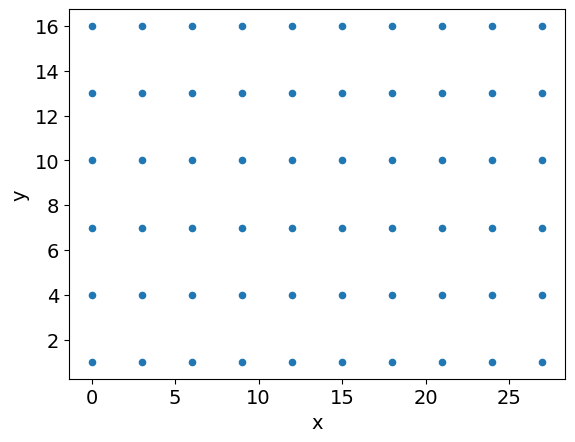

In [386]:
basico_df.plot(kind='scatter', x='x', y='y')

<h3>As linhas equipotenciais desse experimento</h3>

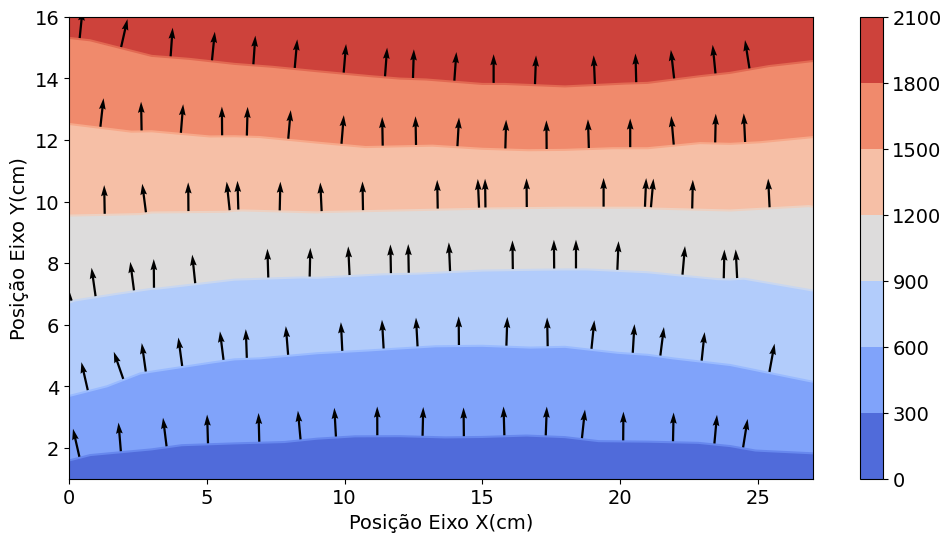

In [387]:
y_vals = basico_df['y'].unique()
plot_contour(basico_df, n_curvas=len(y_vals), file_name='placas_paralelas.png')

<h2>Plotando as linhas equipotenciais para o caso com a ponta entre as placas paralelas:</h2>

In [388]:
partial_ponta_df = pd.read_excel('./dados/experimento_ponta.xlsx')

In [389]:
def sum_and_append(arr, value, increment, iterations):
  for _ in range(iterations):
    value += increment
    arr.append(value)
  
  return value

In [390]:
def complete_df(df):
  '''
  Recebe um df que possui os dados da coluna x incompletos(so foram medidos até metade da folha) e os da coluna y completos, com isso completa 
  df obtendo os pontos faltantes a partir dos pontos coletados utilizando simetria em torno do eixo y
  '''

  y_vals = df['y'].unique()

  final_df = pd.DataFrame(columns=['x', 'y', 'mV']) # cria o df q sera o output

  for val in y_vals:
    selected_y_val_df = df[df['y'] == val].sort_values(by='x') # pega apenas as linhas com um valor de y especifico

    decrescent_x_vals = list(selected_y_val_df['x'].sort_values(ascending=False))

    # esses sao os unicos intervalos possiveis dos df que serão utilizados
    sum_half = 0 # numero de vezes que deve somar .5
    sum_one = 0 # numero de vezes que deve somar 1
    sum_two = 0 # numero de vezes que deve somar 2
    sum_three = 0 # numero de vezes que deve somar 3

    for i in range(len(decrescent_x_vals) - 1):
      diference = decrescent_x_vals[i] - decrescent_x_vals[i + 1]

      if diference == 3:
        sum_three += 1
      elif diference == 2:
        sum_two += 1
      elif diference == 1:
        sum_one += 1
      elif diference == .5:
        sum_half += 1

    max_x_val = int(df['x'].max()) # pega o maior valor de x para ir fazendo as adicoes

    y_vals = np.array([val] * (sum_half + sum_one + sum_two + sum_three))

    # cria um array com os novos valores de x
    x_vals = []
    max_x_val = sum_and_append(x_vals, max_x_val, .5, sum_half)
    max_x_val = sum_and_append(x_vals, max_x_val, 1, sum_one)
    max_x_val = sum_and_append(x_vals, max_x_val, 2, sum_two)
    max_x_val = sum_and_append(x_vals, max_x_val, 3, sum_three)
    x_vals = np.array(x_vals)

    inverted_mv = np.array(selected_y_val_df['mV'][-2::-1])

    inverted_selected_df = pd.DataFrame({'y': y_vals, 'x': x_vals, 'mV': inverted_mv})
    
    final_selected_df = pd.concat([selected_y_val_df, inverted_selected_df])

    final_df = pd.concat([final_df, final_selected_df])

  return final_df.astype(int)

In [391]:
ponta_df = complete_df(partial_ponta_df)

<h3>Distribuição dos pontos que foram utilizados para coletar os dados</h3>

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='x', ylabel='y'>

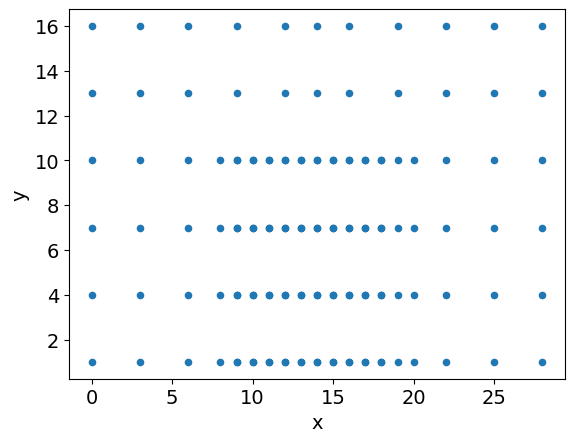

In [392]:
ponta_df[['x', 'y']].plot(kind='scatter', x='x', y='y')

In [393]:
# os valores de mV == 0 são valores que não foram possíveis de medir por conta do objeto estar sobre o ponto, precisa remover esses valores 
# pois eles alteram o desenho das curvas de nível
def remove_zero_values(df, column):
  '''
  Remove as linhas de df em que os valores da coluna column sejam iguais a 0
  '''
  df[column] = df[column].replace(0, np.NaN)
  df = df.dropna()
  return df

In [394]:
ponta_df = remove_zero_values(ponta_df, 'mV')

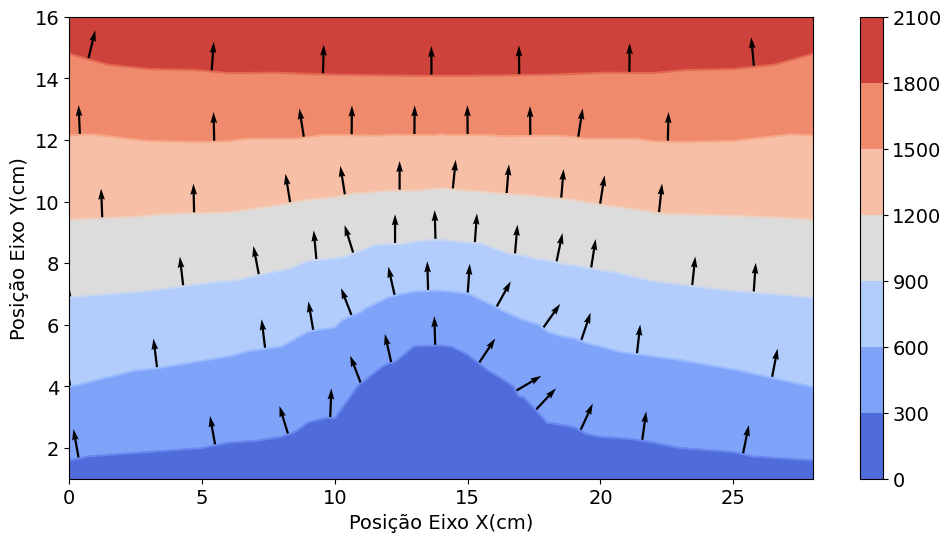

In [395]:
y_vals = ponta_df['y'].unique()
plot_contour(ponta_df, 'ponta.png', 3, len(y_vals))

Plotando as linhas equipotenciais para o caso do anel

In [396]:
partial_ring_df = pd.read_excel('./dados/experimento_anel.xlsx')

In [397]:
ring_df = complete_df(partial_ring_df)

<h3>Distribuição dos pontos que foram utilizados para coletar os dados</h3>

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='x', ylabel='y'>

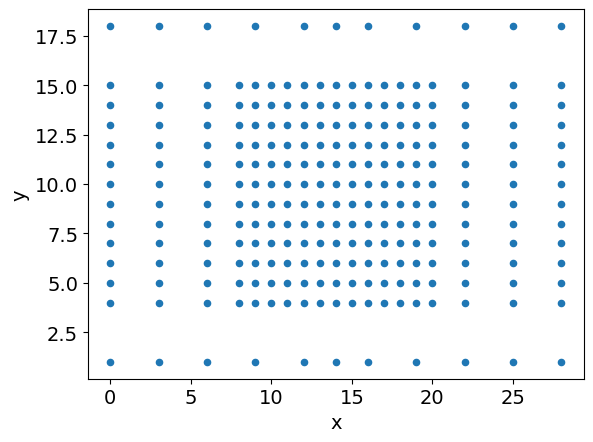

In [398]:
ring_df.plot(kind='scatter', x='x', y='y')

In [399]:
# remove as linhas que tem mV == 0, pois nesses pontos nao foi possivel medir por conta do anel
ring_df = remove_zero_values(ring_df, 'mV')

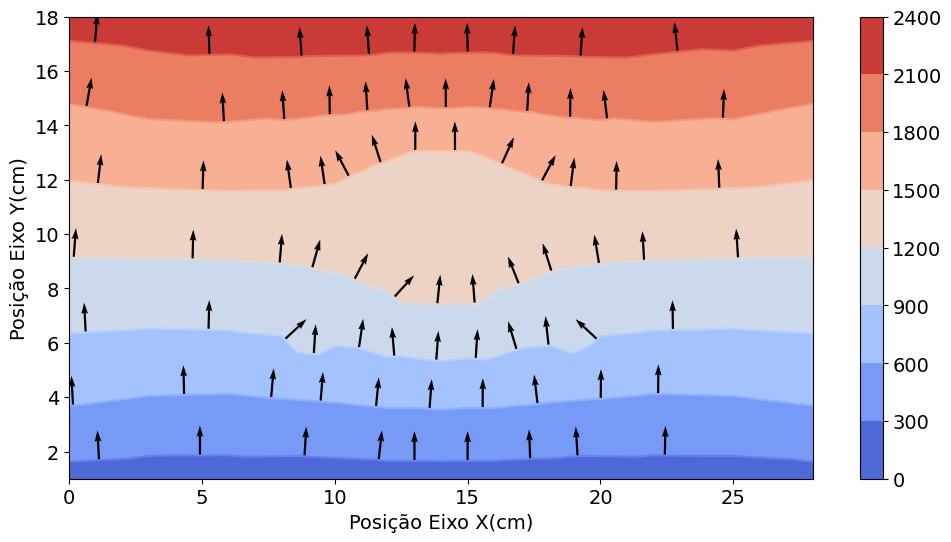

In [400]:
plot_contour(ring_df, razao_pontos=3, file_name='anel.png')

<h3>Usando os pontos coletados no eixo de simetria de cada experimento, será plotado um gráfico do potencial elétrico em função da posição da ponta ao longo do eixo de simetria(y)</h3>

In [401]:
# importa o df que possui todos os dados
all_simetric_df = pd.read_excel('./dados/experimento_eixo_simetria.xlsx')

In [402]:
# cria dfs que representam cada experimento
base_simetric_df = all_simetric_df.drop(columns=['V(Ponta)', 'V(Anel)']).rename(columns={'Altura(Y)': 'y', 'V(Base)': 'mV'}).dropna() # unico q pode conter valores nulos
ponta_simetric_df = all_simetric_df.drop(columns=['V(Base)', 'V(Anel)']).rename(columns={'Altura(Y)': 'y', 'V(Ponta)': 'mV'})
anel_simetric_df = all_simetric_df.drop(columns=['V(Base)', 'V(Ponta)']).rename(columns={'Altura(Y)': 'y', 'V(Anel)': 'mV'})

<h3>Gráfico dos pontos no eixo de simetria do experimento com placas paralelas</h3>

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='mV', ylabel='y'>

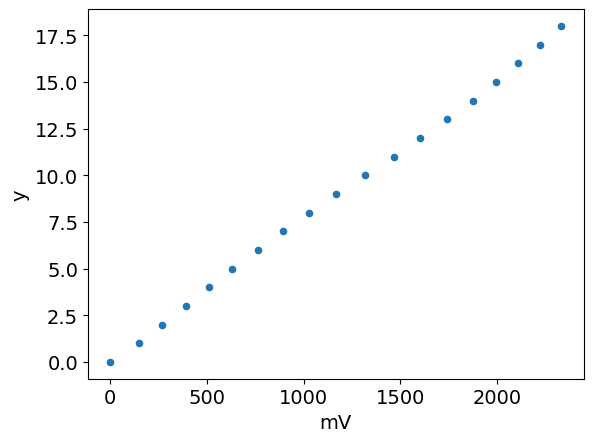

In [403]:
base_simetric_df.plot(kind='scatter', x='mV', y='y')

<h3>Gráfico dos pontos no eixo de simetria do experimento com ponta</h3>

<Axes: xlabel='mV', ylabel='y'>

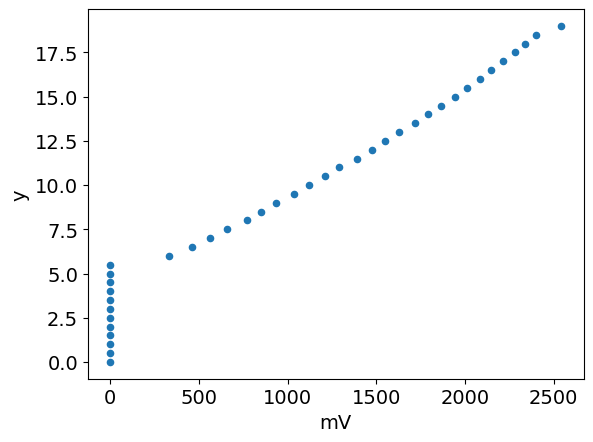

In [404]:
ponta_simetric_df.plot(kind='scatter', x='mV', y='y')

# nesse plot os pontos com valores de mV == 0 são pontos que não foram possíveis de medir, pois a ponta estava sobre eles

<h3>Gráfico dos pontos no eixo de simetria do experimento com o anel</h3>

<Axes: xlabel='mV', ylabel='y'>

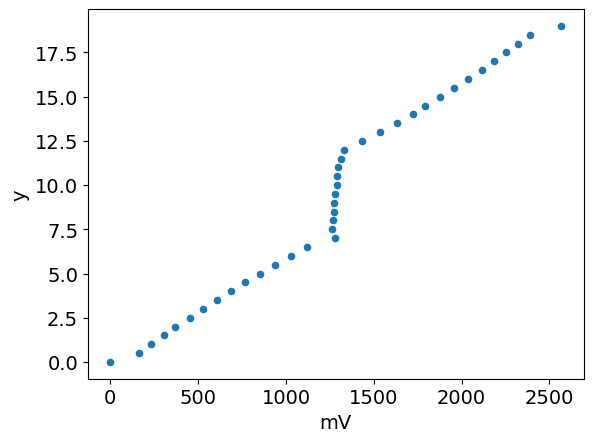

In [405]:
anel_simetric_df.plot(kind='scatter', x='mV', y='y')